In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.1


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                    | 1/2604 [00:00<25:12,  1.72it/s]

  0%|▎                                                                                                                                                   | 5/2604 [00:00<04:45,  9.12it/s]

  0%|▌                                                                                                                                                  | 10/2604 [00:00<02:29, 17.36it/s]

  1%|▊                                                                                                                                                  | 15/2604 [00:00<01:46, 24.25it/s]

  1%|█▏                                                                                                                                                 | 20/2604 [00:01<01:25, 30.35it/s]

  1%|█▍                                                                                                                                                 | 25/2604 [00:01<01:13, 35.18it/s]

  1%|█▋                                                                                                                                                 | 30/2604 [00:01<01:06, 38.93it/s]

  1%|█▉                                                                                                                                                 | 35/2604 [00:01<01:01, 41.80it/s]

  2%|██▎                                                                                                                                                | 40/2604 [00:01<00:58, 43.89it/s]

  2%|██▌                                                                                                                                                | 45/2604 [00:01<00:56, 45.40it/s]

  2%|██▊                                                                                                                                                | 50/2604 [00:01<00:55, 46.40it/s]

  2%|███                                                                                                                                                | 55/2604 [00:01<00:53, 47.20it/s]

  2%|███▍                                                                                                                                               | 60/2604 [00:01<00:53, 47.79it/s]

  2%|███▋                                                                                                                                               | 65/2604 [00:01<00:52, 48.20it/s]

  3%|███▉                                                                                                                                               | 70/2604 [00:02<00:52, 48.49it/s]

  3%|████▏                                                                                                                                              | 75/2604 [00:02<00:51, 48.69it/s]

  3%|████▌                                                                                                                                              | 80/2604 [00:02<00:51, 48.84it/s]

  3%|████▊                                                                                                                                              | 85/2604 [00:02<00:51, 48.93it/s]

  3%|█████                                                                                                                                              | 90/2604 [00:02<00:51, 49.00it/s]

  4%|█████▎                                                                                                                                             | 95/2604 [00:02<00:51, 49.05it/s]

  4%|█████▌                                                                                                                                            | 100/2604 [00:02<00:50, 49.10it/s]

  4%|█████▉                                                                                                                                            | 105/2604 [00:02<00:50, 49.10it/s]

  4%|██████▏                                                                                                                                           | 110/2604 [00:02<00:50, 48.96it/s]

  4%|██████▍                                                                                                                                           | 115/2604 [00:02<00:50, 49.01it/s]

  5%|██████▋                                                                                                                                           | 120/2604 [00:03<00:50, 49.07it/s]

  5%|███████                                                                                                                                           | 125/2604 [00:03<00:50, 49.12it/s]

  5%|███████▎                                                                                                                                          | 130/2604 [00:03<00:50, 49.15it/s]

  5%|███████▌                                                                                                                                          | 135/2604 [00:03<00:50, 49.16it/s]

  5%|███████▊                                                                                                                                          | 140/2604 [00:03<00:50, 49.16it/s]

  6%|████████▏                                                                                                                                         | 145/2604 [00:03<00:50, 49.16it/s]

  6%|████████▍                                                                                                                                         | 150/2604 [00:03<00:49, 49.16it/s]

  6%|████████▋                                                                                                                                         | 155/2604 [00:03<00:49, 49.13it/s]

  6%|████████▉                                                                                                                                         | 160/2604 [00:03<00:49, 49.14it/s]

  6%|█████████▎                                                                                                                                        | 165/2604 [00:03<00:49, 49.03it/s]

  7%|█████████▌                                                                                                                                        | 170/2604 [00:04<00:49, 49.03it/s]

  7%|█████████▊                                                                                                                                        | 175/2604 [00:04<00:49, 49.04it/s]

  7%|██████████                                                                                                                                        | 180/2604 [00:04<00:49, 49.07it/s]

  7%|██████████▎                                                                                                                                       | 185/2604 [00:04<00:49, 49.07it/s]

  7%|██████████▋                                                                                                                                       | 190/2604 [00:04<00:49, 49.10it/s]

  7%|██████████▉                                                                                                                                       | 195/2604 [00:04<00:49, 49.13it/s]

  8%|███████████▏                                                                                                                                      | 200/2604 [00:04<00:48, 49.11it/s]

  8%|███████████▍                                                                                                                                      | 205/2604 [00:04<00:48, 49.11it/s]

  8%|███████████▊                                                                                                                                      | 210/2604 [00:04<00:48, 49.14it/s]

  8%|████████████                                                                                                                                      | 215/2604 [00:04<00:48, 49.14it/s]

  8%|████████████▎                                                                                                                                     | 220/2604 [00:05<00:48, 49.14it/s]

  9%|████████████▌                                                                                                                                     | 225/2604 [00:05<00:48, 49.00it/s]

  9%|████████████▉                                                                                                                                     | 230/2604 [00:05<00:48, 49.06it/s]

  9%|█████████████▏                                                                                                                                    | 235/2604 [00:05<00:48, 49.09it/s]

  9%|█████████████▍                                                                                                                                    | 240/2604 [00:05<00:48, 49.12it/s]

  9%|█████████████▋                                                                                                                                    | 245/2604 [00:05<00:48, 49.14it/s]

 10%|██████████████                                                                                                                                    | 250/2604 [00:05<00:47, 49.21it/s]

 10%|██████████████▎                                                                                                                                   | 255/2604 [00:05<00:47, 49.20it/s]

 10%|██████████████▌                                                                                                                                   | 260/2604 [00:05<00:47, 49.19it/s]

 10%|██████████████▊                                                                                                                                   | 265/2604 [00:06<00:47, 49.17it/s]

 10%|███████████████▏                                                                                                                                  | 270/2604 [00:06<00:47, 49.06it/s]

 11%|███████████████▍                                                                                                                                  | 275/2604 [00:06<00:47, 49.10it/s]

 11%|███████████████▋                                                                                                                                  | 280/2604 [00:06<00:47, 49.12it/s]

 11%|███████████████▉                                                                                                                                  | 285/2604 [00:06<00:47, 49.15it/s]

 11%|████████████████▎                                                                                                                                 | 290/2604 [00:06<00:47, 49.14it/s]

 11%|████████████████▌                                                                                                                                 | 295/2604 [00:06<00:46, 49.14it/s]

 12%|████████████████▊                                                                                                                                 | 300/2604 [00:06<00:46, 49.16it/s]

 12%|█████████████████                                                                                                                                 | 305/2604 [00:06<00:46, 49.17it/s]

 12%|█████████████████▍                                                                                                                                | 310/2604 [00:06<00:46, 49.17it/s]

 12%|█████████████████▋                                                                                                                                | 315/2604 [00:07<00:46, 49.16it/s]

 12%|█████████████████▉                                                                                                                                | 320/2604 [00:07<00:46, 49.26it/s]

 12%|██████████████████▏                                                                                                                               | 325/2604 [00:07<00:46, 49.31it/s]

 13%|██████████████████▌                                                                                                                               | 330/2604 [00:07<00:46, 49.24it/s]

 13%|██████████████████▊                                                                                                                               | 335/2604 [00:07<00:46, 49.23it/s]

 13%|███████████████████                                                                                                                               | 340/2604 [00:07<00:46, 49.20it/s]

 13%|███████████████████▎                                                                                                                              | 345/2604 [00:07<00:45, 49.20it/s]

 13%|███████████████████▌                                                                                                                              | 350/2604 [00:07<00:45, 49.16it/s]

 14%|███████████████████▉                                                                                                                              | 355/2604 [00:07<00:45, 49.03it/s]

 14%|████████████████████▏                                                                                                                             | 360/2604 [00:07<00:45, 49.03it/s]

 14%|████████████████████▍                                                                                                                             | 365/2604 [00:08<00:45, 49.06it/s]

 14%|████████████████████▋                                                                                                                             | 370/2604 [00:08<00:45, 49.09it/s]

 14%|█████████████████████                                                                                                                             | 375/2604 [00:08<00:45, 49.10it/s]

 15%|█████████████████████▎                                                                                                                            | 380/2604 [00:08<00:45, 49.10it/s]

 15%|█████████████████████▌                                                                                                                            | 385/2604 [00:08<00:45, 49.12it/s]

 15%|█████████████████████▊                                                                                                                            | 390/2604 [00:08<00:45, 49.08it/s]

 15%|██████████████████████▏                                                                                                                           | 395/2604 [00:08<00:44, 49.09it/s]

 15%|██████████████████████▍                                                                                                                           | 400/2604 [00:08<00:44, 49.11it/s]

 16%|██████████████████████▋                                                                                                                           | 405/2604 [00:08<00:44, 49.04it/s]

 16%|██████████████████████▉                                                                                                                           | 410/2604 [00:08<00:44, 49.17it/s]

 16%|███████████████████████▎                                                                                                                          | 415/2604 [00:09<00:44, 49.18it/s]

 16%|███████████████████████▌                                                                                                                          | 420/2604 [00:09<00:44, 49.16it/s]

 16%|███████████████████████▊                                                                                                                          | 425/2604 [00:09<00:44, 49.17it/s]

 17%|████████████████████████                                                                                                                          | 430/2604 [00:09<00:44, 49.18it/s]

 17%|████████████████████████▍                                                                                                                         | 435/2604 [00:09<00:44, 49.14it/s]

 17%|████████████████████████▋                                                                                                                         | 440/2604 [00:09<00:44, 49.15it/s]

 17%|████████████████████████▉                                                                                                                         | 445/2604 [00:09<00:43, 49.18it/s]

 17%|█████████████████████████▏                                                                                                                        | 450/2604 [00:09<00:43, 49.16it/s]

 17%|█████████████████████████▌                                                                                                                        | 455/2604 [00:09<00:43, 49.17it/s]

 18%|█████████████████████████▊                                                                                                                        | 460/2604 [00:09<00:43, 49.26it/s]

 18%|██████████████████████████                                                                                                                        | 465/2604 [00:10<00:43, 49.20it/s]

 18%|██████████████████████████▎                                                                                                                       | 470/2604 [00:10<00:43, 49.20it/s]

 18%|██████████████████████████▋                                                                                                                       | 475/2604 [00:10<00:43, 49.20it/s]

 18%|██████████████████████████▉                                                                                                                       | 480/2604 [00:10<00:43, 49.08it/s]

 19%|███████████████████████████▏                                                                                                                      | 485/2604 [00:10<00:43, 49.10it/s]

 19%|███████████████████████████▍                                                                                                                      | 490/2604 [00:10<00:43, 49.12it/s]

 19%|███████████████████████████▊                                                                                                                      | 495/2604 [00:10<00:42, 49.11it/s]

 19%|████████████████████████████                                                                                                                      | 500/2604 [00:10<00:42, 49.12it/s]

 19%|████████████████████████████▎                                                                                                                     | 505/2604 [00:10<00:42, 49.11it/s]

 20%|████████████████████████████▌                                                                                                                     | 510/2604 [00:10<00:42, 49.03it/s]

 20%|████████████████████████████▊                                                                                                                     | 515/2604 [00:11<00:42, 49.32it/s]

 20%|█████████████████████████████▏                                                                                                                    | 520/2604 [00:11<00:42, 49.27it/s]

 20%|█████████████████████████████▍                                                                                                                    | 525/2604 [00:11<00:42, 49.23it/s]

 20%|█████████████████████████████▋                                                                                                                    | 530/2604 [00:11<00:42, 49.11it/s]

 21%|█████████████████████████████▉                                                                                                                    | 535/2604 [00:11<00:42, 49.12it/s]

 21%|██████████████████████████████▎                                                                                                                   | 540/2604 [00:11<00:42, 49.14it/s]

 21%|██████████████████████████████▌                                                                                                                   | 545/2604 [00:11<00:41, 49.17it/s]

 21%|██████████████████████████████▊                                                                                                                   | 550/2604 [00:11<00:41, 49.17it/s]

 21%|███████████████████████████████                                                                                                                   | 555/2604 [00:11<00:41, 49.18it/s]

 22%|███████████████████████████████▍                                                                                                                  | 560/2604 [00:12<00:41, 49.17it/s]

 22%|███████████████████████████████▋                                                                                                                  | 565/2604 [00:12<00:41, 49.17it/s]

 22%|███████████████████████████████▉                                                                                                                  | 570/2604 [00:12<00:41, 49.15it/s]

 22%|████████████████████████████████▏                                                                                                                 | 575/2604 [00:12<00:41, 48.96it/s]

 22%|████████████████████████████████▌                                                                                                                 | 581/2604 [00:12<00:41, 49.26it/s]

 23%|████████████████████████████████▊                                                                                                                 | 586/2604 [00:12<00:40, 49.24it/s]

 23%|█████████████████████████████████▏                                                                                                                | 591/2604 [00:12<00:40, 49.21it/s]

 23%|█████████████████████████████████▍                                                                                                                | 596/2604 [00:12<00:40, 49.21it/s]

 23%|█████████████████████████████████▋                                                                                                                | 601/2604 [00:12<00:40, 49.17it/s]

 23%|█████████████████████████████████▉                                                                                                                | 606/2604 [00:12<00:40, 49.16it/s]

 23%|██████████████████████████████████▎                                                                                                               | 611/2604 [00:13<00:40, 49.16it/s]

 24%|██████████████████████████████████▌                                                                                                               | 616/2604 [00:13<00:40, 49.14it/s]

 24%|██████████████████████████████████▊                                                                                                               | 621/2604 [00:13<00:40, 49.13it/s]

 24%|███████████████████████████████████                                                                                                               | 626/2604 [00:13<00:40, 49.19it/s]

 24%|███████████████████████████████████▍                                                                                                              | 631/2604 [00:13<00:40, 49.29it/s]

 24%|███████████████████████████████████▋                                                                                                              | 636/2604 [00:13<00:39, 49.27it/s]

 25%|███████████████████████████████████▉                                                                                                              | 641/2604 [00:13<00:39, 49.39it/s]

 25%|████████████████████████████████████▏                                                                                                             | 646/2604 [00:13<00:39, 49.43it/s]

 25%|████████████████████████████████████▌                                                                                                             | 652/2604 [00:13<00:39, 49.69it/s]

 25%|████████████████████████████████████▊                                                                                                             | 657/2604 [00:13<00:39, 49.63it/s]

 25%|█████████████████████████████████████                                                                                                             | 662/2604 [00:14<00:39, 49.63it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 667/2604 [00:14<00:39, 49.62it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 672/2604 [00:14<00:38, 49.68it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 677/2604 [00:14<00:38, 49.59it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 682/2604 [00:14<00:38, 49.59it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 687/2604 [00:14<00:38, 49.64it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 692/2604 [00:14<00:38, 49.66it/s]

 27%|███████████████████████████████████████                                                                                                           | 697/2604 [00:14<00:38, 49.69it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 702/2604 [00:14<00:38, 49.68it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 707/2604 [00:14<00:38, 49.70it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 712/2604 [00:15<00:38, 49.72it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 717/2604 [00:15<00:37, 49.75it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 722/2604 [00:15<00:37, 49.77it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 727/2604 [00:15<00:37, 49.69it/s]

 28%|█████████████████████████████████████████                                                                                                         | 732/2604 [00:15<00:37, 49.53it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 737/2604 [00:15<00:37, 49.55it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 742/2604 [00:15<00:37, 49.58it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 747/2604 [00:15<00:37, 49.64it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 752/2604 [00:15<00:37, 49.70it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 757/2604 [00:15<00:37, 49.68it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 762/2604 [00:16<00:37, 49.70it/s]

 29%|███████████████████████████████████████████                                                                                                       | 767/2604 [00:16<00:36, 49.71it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 772/2604 [00:16<00:36, 49.72it/s]

 30%|███████████████████████████████████████████▌                                                                                                      | 777/2604 [00:16<00:36, 49.75it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 782/2604 [00:16<00:36, 49.63it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 787/2604 [00:16<00:36, 49.67it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 792/2604 [00:16<00:36, 49.72it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 797/2604 [00:16<00:36, 49.73it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 802/2604 [00:16<00:36, 49.74it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 807/2604 [00:16<00:36, 49.72it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 812/2604 [00:17<00:36, 49.69it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 817/2604 [00:17<00:35, 49.70it/s]

 32%|██████████████████████████████████████████████▏                                                                                                   | 823/2604 [00:17<00:35, 49.86it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 828/2604 [00:17<00:35, 49.82it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 833/2604 [00:17<00:35, 49.73it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 838/2604 [00:17<00:35, 49.76it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 843/2604 [00:17<00:35, 49.80it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 848/2604 [00:17<00:35, 49.76it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 853/2604 [00:17<00:35, 49.73it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 858/2604 [00:18<00:35, 49.73it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 863/2604 [00:18<00:35, 49.72it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 868/2604 [00:18<00:34, 49.73it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 873/2604 [00:18<00:34, 49.79it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 878/2604 [00:18<00:34, 49.77it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 883/2604 [00:18<00:34, 49.74it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 888/2604 [00:18<00:34, 49.74it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 893/2604 [00:18<00:34, 49.69it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 898/2604 [00:18<00:34, 49.72it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 903/2604 [00:18<00:34, 49.78it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 908/2604 [00:19<00:34, 49.76it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 913/2604 [00:19<00:33, 49.76it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 918/2604 [00:19<00:33, 49.77it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 923/2604 [00:19<00:33, 49.72it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 929/2604 [00:19<00:33, 50.02it/s]

 36%|████████████████████████████████████████████████████▎                                                                                             | 934/2604 [00:19<00:33, 49.97it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 939/2604 [00:19<00:33, 49.89it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 944/2604 [00:19<00:33, 49.85it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                            | 949/2604 [00:19<00:33, 49.83it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 954/2604 [00:19<00:33, 49.80it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 959/2604 [00:20<00:33, 49.81it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 964/2604 [00:20<00:32, 49.81it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 969/2604 [00:20<00:32, 49.82it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 974/2604 [00:20<00:32, 49.76it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 979/2604 [00:20<00:32, 49.72it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 984/2604 [00:20<00:32, 49.66it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 989/2604 [00:20<00:32, 49.69it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 994/2604 [00:20<00:32, 49.72it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 999/2604 [00:20<00:32, 49.76it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 1004/2604 [00:20<00:32, 49.72it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 1009/2604 [00:21<00:32, 49.71it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 1014/2604 [00:21<00:31, 49.72it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                        | 1019/2604 [00:21<00:31, 49.73it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 1024/2604 [00:21<00:31, 49.74it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 1029/2604 [00:21<00:31, 49.77it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 1034/2604 [00:21<00:31, 49.80it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 1039/2604 [00:21<00:31, 49.67it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 1045/2604 [00:21<00:31, 50.01it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 1050/2604 [00:21<00:31, 49.89it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                      | 1055/2604 [00:21<00:31, 49.84it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 1060/2604 [00:22<00:30, 49.83it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 1065/2604 [00:22<00:30, 49.77it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                     | 1070/2604 [00:22<00:30, 49.76it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 1075/2604 [00:22<00:30, 49.76it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 1080/2604 [00:22<00:30, 49.77it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                    | 1085/2604 [00:22<00:30, 49.71it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 1090/2604 [00:22<00:30, 49.67it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 1095/2604 [00:22<00:30, 49.60it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 1100/2604 [00:22<00:30, 49.65it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 1105/2604 [00:22<00:30, 49.69it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 1110/2604 [00:23<00:30, 49.70it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 1115/2604 [00:23<00:29, 49.70it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 1120/2604 [00:23<00:29, 49.56it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 1125/2604 [00:23<00:29, 49.51it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 1130/2604 [00:23<00:29, 49.53it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 1135/2604 [00:23<00:29, 49.56it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                 | 1140/2604 [00:23<00:29, 49.64it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 1145/2604 [00:23<00:29, 49.66it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 1150/2604 [00:23<00:29, 49.57it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 1155/2604 [00:23<00:29, 49.56it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 1160/2604 [00:24<00:29, 49.59it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 1165/2604 [00:24<00:28, 49.66it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 1170/2604 [00:24<00:28, 49.57it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 1175/2604 [00:24<00:28, 49.61it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 1180/2604 [00:24<00:28, 49.69it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                               | 1185/2604 [00:24<00:28, 49.70it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 1190/2604 [00:24<00:28, 49.60it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 1195/2604 [00:24<00:28, 49.58it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 1200/2604 [00:24<00:28, 49.49it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 1205/2604 [00:25<00:28, 49.55it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                             | 1210/2604 [00:25<00:28, 49.61it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 1215/2604 [00:25<00:27, 49.66it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 1220/2604 [00:25<00:27, 49.69it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 1225/2604 [00:25<00:27, 49.64it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 1230/2604 [00:25<00:27, 49.61it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 1235/2604 [00:25<00:27, 49.62it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 1240/2604 [00:25<00:27, 49.66it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 1245/2604 [00:25<00:27, 49.66it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 1250/2604 [00:25<00:27, 49.72it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 1255/2604 [00:26<00:27, 49.69it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 1260/2604 [00:26<00:27, 49.48it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 1265/2604 [00:26<00:27, 49.51it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 1270/2604 [00:26<00:26, 49.58it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 1275/2604 [00:26<00:26, 49.63it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 1280/2604 [00:26<00:26, 49.65it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 1285/2604 [00:26<00:26, 49.69it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 1290/2604 [00:26<00:26, 49.71it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                         | 1295/2604 [00:26<00:26, 49.63it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 1300/2604 [00:26<00:26, 49.60it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 1305/2604 [00:27<00:26, 49.63it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 1310/2604 [00:27<00:26, 49.66it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 1315/2604 [00:27<00:26, 49.49it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 1321/2604 [00:27<00:25, 49.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                       | 1326/2604 [00:27<00:25, 49.80it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                       | 1331/2604 [00:27<00:25, 49.74it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 1336/2604 [00:27<00:25, 49.72it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 1341/2604 [00:27<00:25, 49.74it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 1346/2604 [00:27<00:25, 49.77it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 1351/2604 [00:27<00:25, 49.76it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 1356/2604 [00:28<00:25, 49.72it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 1361/2604 [00:28<00:25, 49.69it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 1366/2604 [00:28<00:24, 49.68it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 1371/2604 [00:28<00:24, 49.71it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 1376/2604 [00:28<00:24, 49.72it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 1381/2604 [00:28<00:24, 49.76it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 1386/2604 [00:28<00:24, 49.80it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 1391/2604 [00:28<00:24, 49.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 1396/2604 [00:28<00:24, 49.85it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 1401/2604 [00:28<00:24, 49.73it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 1406/2604 [00:29<00:24, 49.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                  | 1411/2604 [00:29<00:24, 49.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                  | 1416/2604 [00:29<00:23, 49.67it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 1421/2604 [00:29<00:23, 49.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                 | 1426/2604 [00:29<00:23, 49.74it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                 | 1431/2604 [00:29<00:23, 49.77it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 1436/2604 [00:29<00:23, 49.75it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 1441/2604 [00:29<00:23, 49.75it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                                | 1446/2604 [00:29<00:23, 49.78it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 1451/2604 [00:29<00:23, 49.78it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                | 1456/2604 [00:30<00:23, 49.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 1461/2604 [00:30<00:23, 49.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 1466/2604 [00:30<00:22, 49.65it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 1471/2604 [00:30<00:22, 49.57it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 1476/2604 [00:30<00:22, 49.66it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 1481/2604 [00:30<00:22, 49.68it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 1486/2604 [00:30<00:22, 49.72it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                              | 1491/2604 [00:30<00:22, 49.70it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 1496/2604 [00:30<00:22, 49.74it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                             | 1501/2604 [00:30<00:22, 49.76it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 1506/2604 [00:31<00:22, 49.75it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1511/2604 [00:31<00:21, 49.77it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1516/2604 [00:31<00:21, 49.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1521/2604 [00:31<00:21, 49.76it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1526/2604 [00:31<00:21, 49.76it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1531/2604 [00:31<00:21, 49.77it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1536/2604 [00:31<00:21, 49.80it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1541/2604 [00:31<00:21, 49.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 1546/2604 [00:31<00:21, 49.80it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1551/2604 [00:31<00:21, 49.83it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1556/2604 [00:32<00:21, 49.84it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1561/2604 [00:32<00:20, 49.76it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1566/2604 [00:32<00:20, 49.68it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1571/2604 [00:32<00:20, 49.68it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1576/2604 [00:32<00:20, 49.66it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 1581/2604 [00:32<00:20, 49.73it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1586/2604 [00:32<00:20, 49.64it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1591/2604 [00:32<00:20, 49.70it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1596/2604 [00:32<00:20, 49.73it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1601/2604 [00:32<00:20, 49.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1606/2604 [00:33<00:20, 49.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1611/2604 [00:33<00:19, 49.70it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1616/2604 [00:33<00:19, 49.75it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1621/2604 [00:33<00:19, 49.80it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1626/2604 [00:33<00:19, 49.78it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1631/2604 [00:33<00:19, 49.81it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 1636/2604 [00:33<00:19, 49.67it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1641/2604 [00:33<00:19, 49.68it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1646/2604 [00:33<00:19, 49.69it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1651/2604 [00:33<00:19, 49.73it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1656/2604 [00:34<00:19, 49.76it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1661/2604 [00:34<00:18, 49.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1666/2604 [00:34<00:18, 49.74it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1672/2604 [00:34<00:18, 49.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1677/2604 [00:34<00:18, 49.70it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1682/2604 [00:34<00:18, 49.70it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1687/2604 [00:34<00:18, 49.72it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1692/2604 [00:34<00:18, 49.73it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1697/2604 [00:34<00:18, 49.75it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1702/2604 [00:34<00:18, 49.77it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1707/2604 [00:35<00:18, 49.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1712/2604 [00:35<00:17, 49.72it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1717/2604 [00:35<00:17, 49.67it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1722/2604 [00:35<00:17, 49.67it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1727/2604 [00:35<00:17, 49.60it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1732/2604 [00:35<00:17, 49.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1737/2604 [00:35<00:17, 49.71it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1742/2604 [00:35<00:17, 49.76it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1747/2604 [00:35<00:17, 49.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1752/2604 [00:36<00:17, 49.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1757/2604 [00:36<00:17, 49.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1762/2604 [00:36<00:16, 49.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1767/2604 [00:36<00:16, 49.74it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1772/2604 [00:36<00:16, 49.75it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1777/2604 [00:36<00:16, 49.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1782/2604 [00:36<00:16, 49.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1787/2604 [00:36<00:16, 49.71it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1792/2604 [00:36<00:16, 49.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1797/2604 [00:36<00:16, 49.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1802/2604 [00:37<00:16, 49.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1807/2604 [00:37<00:16, 49.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1812/2604 [00:37<00:15, 49.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1817/2604 [00:37<00:15, 49.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1822/2604 [00:37<00:15, 49.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1827/2604 [00:37<00:15, 49.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1832/2604 [00:37<00:15, 49.67it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1837/2604 [00:37<00:15, 49.67it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1842/2604 [00:37<00:15, 49.63it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1847/2604 [00:37<00:15, 49.68it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1852/2604 [00:38<00:15, 49.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1857/2604 [00:38<00:15, 49.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1862/2604 [00:38<00:14, 49.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1867/2604 [00:38<00:14, 49.73it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1872/2604 [00:38<00:14, 49.48it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1878/2604 [00:38<00:14, 49.73it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1884/2604 [00:38<00:14, 50.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1890/2604 [00:38<00:14, 49.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1895/2604 [00:38<00:14, 49.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1900/2604 [00:38<00:14, 49.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1905/2604 [00:39<00:14, 49.76it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1910/2604 [00:39<00:13, 49.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1915/2604 [00:39<00:13, 49.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1920/2604 [00:39<00:13, 49.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2604 [00:39<00:13, 49.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1930/2604 [00:39<00:13, 49.70it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1935/2604 [00:39<00:13, 49.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1940/2604 [00:39<00:13, 49.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1945/2604 [00:39<00:13, 49.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1950/2604 [00:39<00:13, 49.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2604 [00:40<00:13, 49.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2604 [00:40<00:12, 49.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2604 [00:40<00:12, 49.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1970/2604 [00:40<00:12, 49.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1975/2604 [00:40<00:12, 49.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1980/2604 [00:40<00:12, 49.65it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1985/2604 [00:40<00:12, 49.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1990/2604 [00:40<00:12, 49.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1995/2604 [00:40<00:12, 49.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2000/2604 [00:40<00:12, 49.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2005/2604 [00:41<00:12, 49.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2010/2604 [00:41<00:11, 49.73it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2015/2604 [00:41<00:11, 49.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2020/2604 [00:41<00:11, 49.72it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2025/2604 [00:41<00:11, 49.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2030/2604 [00:41<00:11, 49.70it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2035/2604 [00:41<00:11, 49.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2040/2604 [00:41<00:11, 49.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2045/2604 [00:41<00:11, 49.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2050/2604 [00:41<00:11, 49.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2055/2604 [00:42<00:11, 49.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2060/2604 [00:42<00:10, 49.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2065/2604 [00:42<00:10, 49.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2070/2604 [00:42<00:10, 49.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2075/2604 [00:42<00:10, 49.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2080/2604 [00:42<00:10, 49.83it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2085/2604 [00:42<00:10, 49.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2090/2604 [00:42<00:10, 49.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2095/2604 [00:42<00:10, 49.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2100/2604 [00:42<00:10, 49.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2105/2604 [00:43<00:10, 49.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2111/2604 [00:43<00:09, 50.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2117/2604 [00:43<00:09, 49.94it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2122/2604 [00:43<00:09, 49.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2127/2604 [00:43<00:09, 49.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2132/2604 [00:43<00:09, 49.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2137/2604 [00:43<00:09, 49.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2142/2604 [00:43<00:09, 49.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2147/2604 [00:43<00:09, 49.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2152/2604 [00:44<00:09, 49.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2157/2604 [00:44<00:08, 49.67it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2162/2604 [00:44<00:08, 49.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2167/2604 [00:44<00:08, 49.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2172/2604 [00:44<00:08, 49.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2177/2604 [00:44<00:08, 49.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2182/2604 [00:44<00:08, 49.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2187/2604 [00:44<00:08, 49.67it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2192/2604 [00:44<00:08, 49.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2197/2604 [00:44<00:08, 49.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2202/2604 [00:45<00:08, 49.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2207/2604 [00:45<00:07, 49.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2212/2604 [00:45<00:07, 49.77it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2217/2604 [00:45<00:07, 49.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2222/2604 [00:45<00:07, 49.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2227/2604 [00:45<00:07, 49.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2232/2604 [00:45<00:07, 49.64it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2237/2604 [00:45<00:07, 49.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2242/2604 [00:45<00:07, 49.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2247/2604 [00:45<00:07, 49.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2252/2604 [00:46<00:07, 49.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2257/2604 [00:46<00:06, 49.73it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2262/2604 [00:46<00:06, 49.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2267/2604 [00:46<00:06, 49.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2272/2604 [00:46<00:06, 49.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2277/2604 [00:46<00:06, 49.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2282/2604 [00:46<00:06, 49.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2287/2604 [00:46<00:06, 49.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2292/2604 [00:46<00:06, 49.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2297/2604 [00:46<00:06, 49.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2302/2604 [00:47<00:06, 49.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2307/2604 [00:47<00:05, 49.68it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2312/2604 [00:47<00:05, 49.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2317/2604 [00:47<00:05, 49.73it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2322/2604 [00:47<00:05, 49.73it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2327/2604 [00:47<00:05, 49.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2332/2604 [00:47<00:05, 49.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2337/2604 [00:47<00:05, 49.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2342/2604 [00:47<00:05, 49.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2347/2604 [00:47<00:05, 49.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2352/2604 [00:48<00:05, 49.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2357/2604 [00:48<00:04, 49.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2362/2604 [00:48<00:04, 49.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2367/2604 [00:48<00:04, 49.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2372/2604 [00:48<00:04, 49.35it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2377/2604 [00:48<00:04, 49.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2382/2604 [00:48<00:04, 48.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2387/2604 [00:48<00:04, 48.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2392/2604 [00:48<00:04, 48.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2397/2604 [00:48<00:04, 48.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2402/2604 [00:49<00:04, 48.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2407/2604 [00:49<00:04, 48.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2412/2604 [00:49<00:03, 48.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2417/2604 [00:49<00:03, 48.51it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2422/2604 [00:49<00:03, 48.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2427/2604 [00:49<00:03, 48.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2432/2604 [00:49<00:03, 48.40it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2437/2604 [00:49<00:03, 48.46it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2442/2604 [00:49<00:03, 48.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2447/2604 [00:50<00:03, 48.51it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2452/2604 [00:50<00:03, 48.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2457/2604 [00:50<00:03, 48.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2462/2604 [00:50<00:02, 48.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2467/2604 [00:50<00:02, 48.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2472/2604 [00:50<00:02, 48.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2477/2604 [00:50<00:02, 48.46it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2482/2604 [00:50<00:02, 48.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2487/2604 [00:50<00:02, 48.43it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2492/2604 [00:50<00:02, 48.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2497/2604 [00:51<00:02, 48.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2502/2604 [00:51<00:02, 48.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2507/2604 [00:51<00:02, 48.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2512/2604 [00:51<00:01, 48.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2517/2604 [00:51<00:01, 48.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2522/2604 [00:51<00:01, 48.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2527/2604 [00:51<00:01, 48.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2532/2604 [00:51<00:01, 48.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2537/2604 [00:51<00:01, 48.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2542/2604 [00:51<00:01, 48.64it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2547/2604 [00:52<00:01, 48.60it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2552/2604 [00:52<00:01, 48.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2557/2604 [00:52<00:00, 48.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2562/2604 [00:52<00:00, 48.43it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2567/2604 [00:52<00:00, 48.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2572/2604 [00:52<00:00, 48.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2577/2604 [00:52<00:00, 48.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2582/2604 [00:52<00:00, 48.49it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2587/2604 [00:52<00:00, 48.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2592/2604 [00:53<00:00, 48.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2597/2604 [00:53<00:00, 46.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [00:53<00:00, 47.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:53<00:00, 48.84it/s]

train - OK


  0%|                                                                                                                                                             | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/339 [00:00<01:37,  3.47it/s]

  2%|██▋                                                                                                                                                  | 6/339 [00:00<00:18, 18.27it/s]

  3%|████▊                                                                                                                                               | 11/339 [00:00<00:11, 27.74it/s]

  5%|██████▉                                                                                                                                             | 16/339 [00:00<00:09, 33.96it/s]

  6%|█████████▏                                                                                                                                          | 21/339 [00:00<00:08, 38.14it/s]

  8%|███████████▎                                                                                                                                        | 26/339 [00:00<00:07, 40.98it/s]

  9%|█████████████▌                                                                                                                                      | 31/339 [00:00<00:07, 42.92it/s]

 11%|███████████████▋                                                                                                                                    | 36/339 [00:01<00:06, 44.28it/s]

 12%|█████████████████▉                                                                                                                                  | 41/339 [00:01<00:06, 45.27it/s]

 14%|████████████████████                                                                                                                                | 46/339 [00:01<00:06, 46.18it/s]

 15%|██████████████████████▎                                                                                                                             | 51/339 [00:01<00:06, 46.83it/s]

 17%|████████████████████████▍                                                                                                                           | 56/339 [00:01<00:05, 47.29it/s]

 18%|██████████████████████████▋                                                                                                                         | 61/339 [00:01<00:05, 47.62it/s]

 19%|████████████████████████████▊                                                                                                                       | 66/339 [00:01<00:05, 47.87it/s]

 21%|██████████████████████████████▉                                                                                                                     | 71/339 [00:01<00:05, 47.97it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 76/339 [00:01<00:05, 48.13it/s]

 24%|███████████████████████████████████▎                                                                                                                | 81/339 [00:01<00:05, 48.08it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 86/339 [00:02<00:05, 47.85it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 91/339 [00:02<00:05, 48.08it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 96/339 [00:02<00:05, 48.15it/s]

 30%|███████████████████████████████████████████▊                                                                                                       | 101/339 [00:02<00:04, 48.18it/s]

 31%|█████████████████████████████████████████████▉                                                                                                     | 106/339 [00:02<00:04, 47.95it/s]

 33%|████████████████████████████████████████████████▏                                                                                                  | 111/339 [00:02<00:04, 48.00it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 116/339 [00:02<00:04, 48.10it/s]

 36%|████████████████████████████████████████████████████▍                                                                                              | 121/339 [00:02<00:04, 48.16it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                            | 126/339 [00:02<00:04, 48.22it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 131/339 [00:03<00:04, 48.32it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 136/339 [00:03<00:04, 48.35it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 141/339 [00:03<00:04, 48.40it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 146/339 [00:03<00:03, 48.46it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                 | 151/339 [00:03<00:03, 48.27it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 156/339 [00:03<00:03, 48.06it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 161/339 [00:03<00:03, 48.18it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 166/339 [00:03<00:03, 48.22it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 171/339 [00:03<00:03, 48.28it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 176/339 [00:03<00:03, 48.24it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 181/339 [00:04<00:03, 48.28it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 186/339 [00:04<00:03, 48.29it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 191/339 [00:04<00:03, 48.32it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 196/339 [00:04<00:02, 48.32it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 201/339 [00:04<00:02, 48.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 206/339 [00:04<00:02, 48.41it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 211/339 [00:04<00:02, 48.47it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 216/339 [00:04<00:02, 48.51it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 221/339 [00:04<00:02, 48.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 226/339 [00:04<00:02, 48.12it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 231/339 [00:05<00:02, 48.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 236/339 [00:05<00:02, 48.32it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 241/339 [00:05<00:02, 48.38it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 246/339 [00:05<00:01, 48.00it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 251/339 [00:05<00:01, 48.11it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 256/339 [00:05<00:01, 48.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 261/339 [00:05<00:01, 48.29it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 266/339 [00:05<00:01, 48.05it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 271/339 [00:05<00:01, 48.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 276/339 [00:06<00:01, 48.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 281/339 [00:06<00:01, 48.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 286/339 [00:06<00:01, 47.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 291/339 [00:06<00:00, 48.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 296/339 [00:06<00:00, 48.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 301/339 [00:06<00:00, 48.21it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 306/339 [00:06<00:00, 48.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 311/339 [00:06<00:00, 48.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 316/339 [00:06<00:00, 47.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 321/339 [00:06<00:00, 48.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 326/339 [00:07<00:00, 48.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 331/339 [00:07<00:00, 48.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:07<00:00, 48.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:07<00:00, 45.58it/s]

val - OK


  0%|                                                                                                                                                             | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/340 [00:00<01:47,  3.16it/s]

  2%|██▋                                                                                                                                                  | 6/340 [00:00<00:19, 17.42it/s]

  3%|████▊                                                                                                                                               | 11/340 [00:00<00:12, 26.76it/s]

  5%|██████▉                                                                                                                                             | 16/340 [00:00<00:09, 33.25it/s]

  6%|█████████▏                                                                                                                                          | 21/340 [00:00<00:08, 37.73it/s]

  8%|███████████▎                                                                                                                                        | 26/340 [00:00<00:07, 40.81it/s]

  9%|█████████████▍                                                                                                                                      | 31/340 [00:00<00:07, 42.82it/s]

 11%|███████████████▋                                                                                                                                    | 36/340 [00:01<00:06, 44.12it/s]

 12%|█████████████████▊                                                                                                                                  | 41/340 [00:01<00:06, 45.26it/s]

 14%|████████████████████                                                                                                                                | 46/340 [00:01<00:06, 46.04it/s]

 15%|██████████████████████▏                                                                                                                             | 51/340 [00:01<00:06, 46.70it/s]

 16%|████████████████████████▍                                                                                                                           | 56/340 [00:01<00:06, 46.94it/s]

 18%|██████████████████████████▌                                                                                                                         | 61/340 [00:01<00:05, 47.49it/s]

 19%|████████████████████████████▋                                                                                                                       | 66/340 [00:01<00:05, 47.90it/s]

 21%|██████████████████████████████▉                                                                                                                     | 71/340 [00:01<00:05, 48.26it/s]

 22%|█████████████████████████████████                                                                                                                   | 76/340 [00:01<00:05, 48.40it/s]

 24%|███████████████████████████████████▎                                                                                                                | 81/340 [00:01<00:05, 48.23it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 86/340 [00:02<00:05, 48.41it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 91/340 [00:02<00:05, 48.60it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 96/340 [00:02<00:05, 48.72it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 101/340 [00:02<00:04, 48.52it/s]

 31%|█████████████████████████████████████████████▊                                                                                                     | 106/340 [00:02<00:04, 48.50it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 111/340 [00:02<00:04, 48.54it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 116/340 [00:02<00:04, 48.66it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 121/340 [00:02<00:04, 48.74it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 126/340 [00:02<00:04, 48.43it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 131/340 [00:03<00:04, 48.56it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 136/340 [00:03<00:04, 48.66it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 141/340 [00:03<00:04, 48.77it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 146/340 [00:03<00:03, 48.86it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 151/340 [00:03<00:03, 48.91it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 156/340 [00:03<00:03, 48.93it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 161/340 [00:03<00:03, 48.91it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 166/340 [00:03<00:03, 48.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 171/340 [00:03<00:03, 48.88it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 176/340 [00:03<00:03, 48.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 181/340 [00:04<00:03, 48.91it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 186/340 [00:04<00:03, 48.97it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 191/340 [00:04<00:03, 48.93it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 196/340 [00:04<00:02, 48.54it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 201/340 [00:04<00:02, 48.69it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 206/340 [00:04<00:02, 48.80it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 211/340 [00:04<00:02, 48.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 216/340 [00:04<00:02, 48.63it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 221/340 [00:04<00:02, 48.56it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 226/340 [00:04<00:02, 48.68it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 231/340 [00:05<00:02, 48.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 236/340 [00:05<00:02, 48.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 241/340 [00:05<00:02, 48.53it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 246/340 [00:05<00:01, 48.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 251/340 [00:05<00:01, 48.74it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 256/340 [00:05<00:01, 48.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 261/340 [00:05<00:01, 48.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 266/340 [00:05<00:01, 48.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 271/340 [00:05<00:01, 48.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 276/340 [00:05<00:01, 48.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 281/340 [00:06<00:01, 48.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 286/340 [00:06<00:01, 48.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 291/340 [00:06<00:01, 48.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 296/340 [00:06<00:00, 48.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 301/340 [00:06<00:00, 49.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 306/340 [00:06<00:00, 48.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 311/340 [00:06<00:00, 48.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 316/340 [00:06<00:00, 48.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 321/340 [00:06<00:00, 48.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 326/340 [00:07<00:00, 48.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 331/340 [00:07<00:00, 48.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 336/340 [00:07<00:00, 48.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:07<00:00, 45.87it/s]

test InD - OK


  0%|                                                                                                                                                              | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                  | 1/42 [00:00<00:14,  2.89it/s]

 14%|█████████████████████▍                                                                                                                                | 6/42 [00:00<00:02, 16.34it/s]

 26%|███████████████████████████████████████                                                                                                              | 11/42 [00:00<00:01, 25.79it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 16/42 [00:00<00:00, 32.34it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 21/42 [00:00<00:00, 37.16it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26/42 [00:00<00:00, 40.52it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31/42 [00:00<00:00, 42.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 36/42 [00:01<00:00, 44.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:01<00:00, 45.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.06it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  6%|████████▉                                                                                                                                            | 6/100 [00:00<00:01, 52.60it/s]

 12%|█████████████████▊                                                                                                                                  | 12/100 [00:00<00:01, 52.64it/s]

 18%|██████████████████████████▋                                                                                                                         | 18/100 [00:00<00:01, 52.74it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:01, 52.75it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 30/100 [00:00<00:01, 52.77it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 36/100 [00:00<00:01, 52.81it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 42/100 [00:00<00:01, 52.85it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:00, 52.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 54/100 [00:01<00:00, 52.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 60/100 [00:01<00:00, 52.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 66/100 [00:01<00:00, 52.93it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:01<00:00, 52.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 78/100 [00:01<00:00, 52.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 84/100 [00:01<00:00, 52.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 90/100 [00:01<00:00, 52.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 52.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.88it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 3) (43520,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 3) (5270,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 3)


In [11]:
# create tsne embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


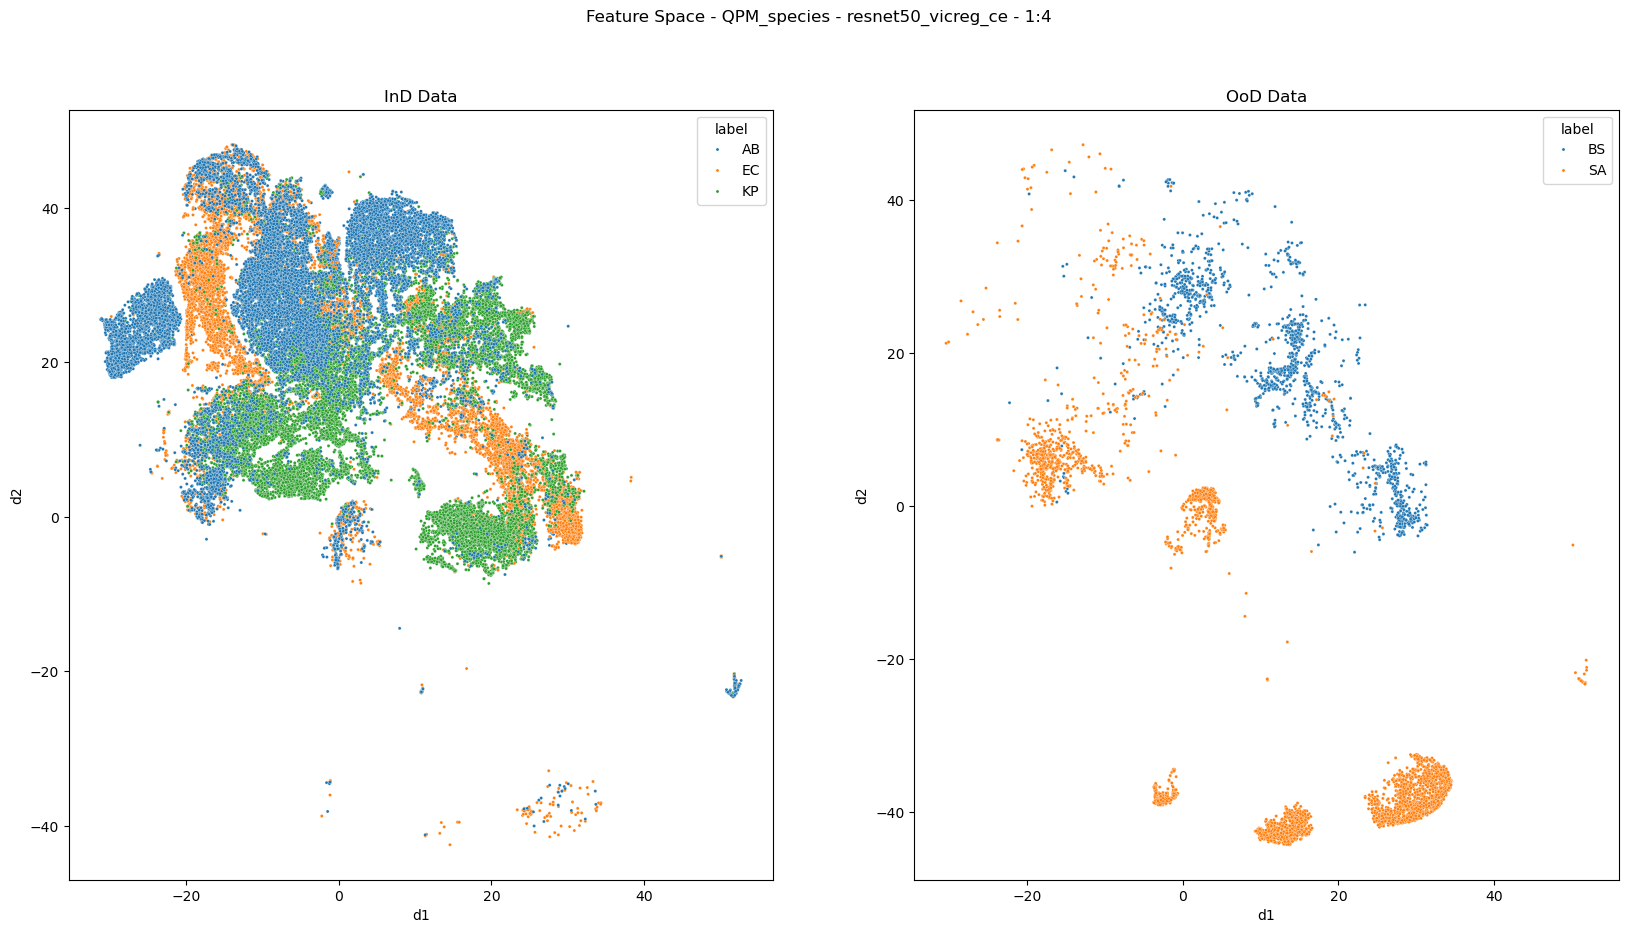

In [12]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

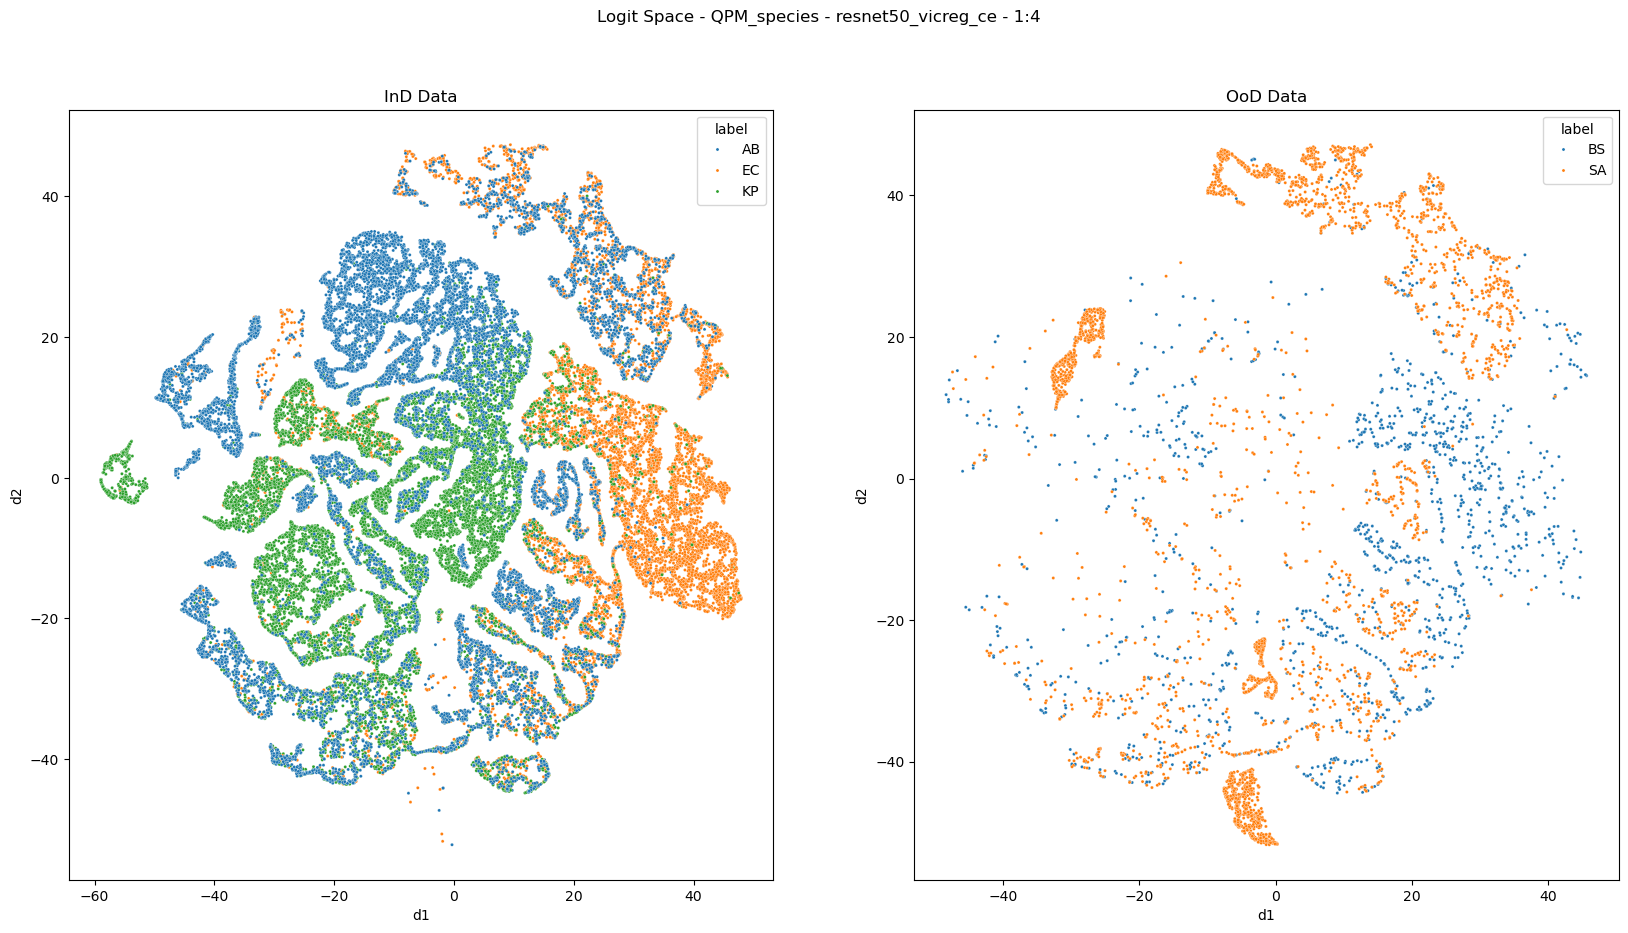

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:54<02:43, 54.50s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [01:49<01:49, 54.54s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [02:43<00:54, 54.65s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:39<00:00, 54.89s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:39<00:00, 54.78s/it]

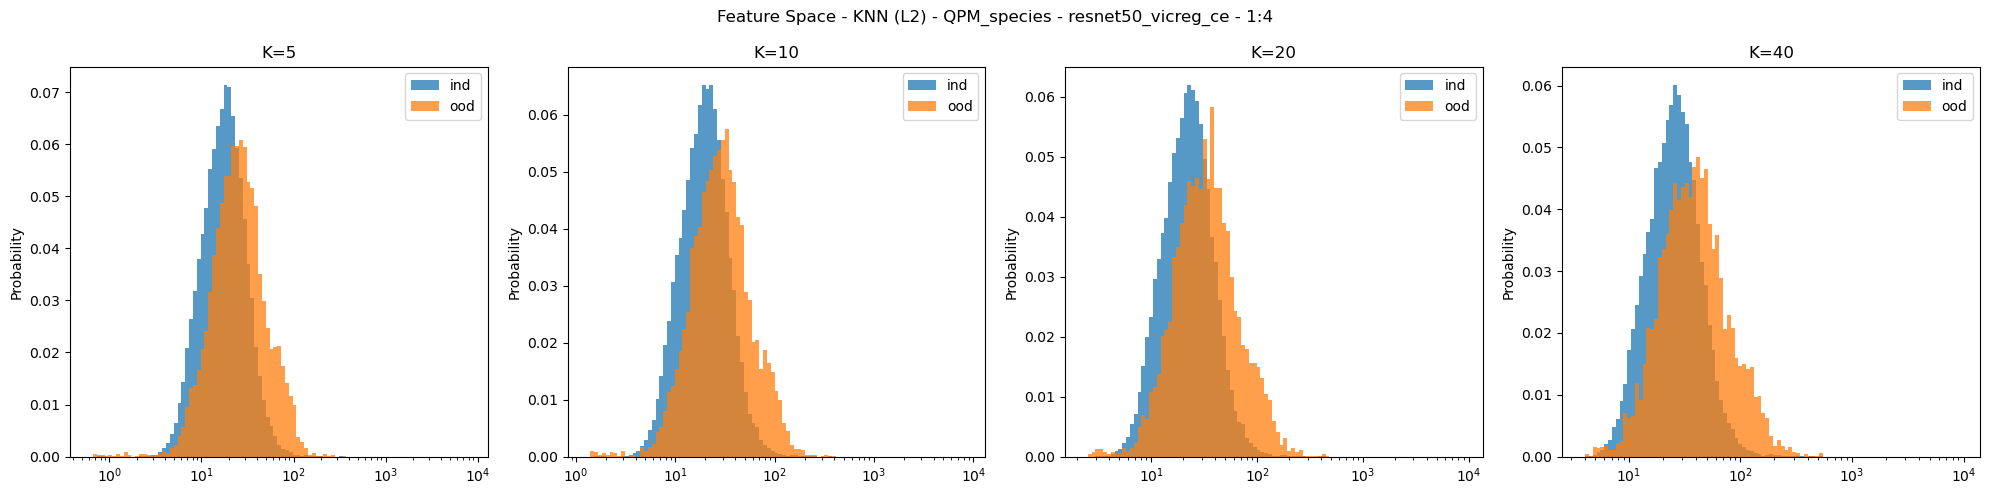

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:54<02:42, 54.24s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [01:48<01:48, 54.41s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [02:43<00:54, 54.47s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.67s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.57s/it]

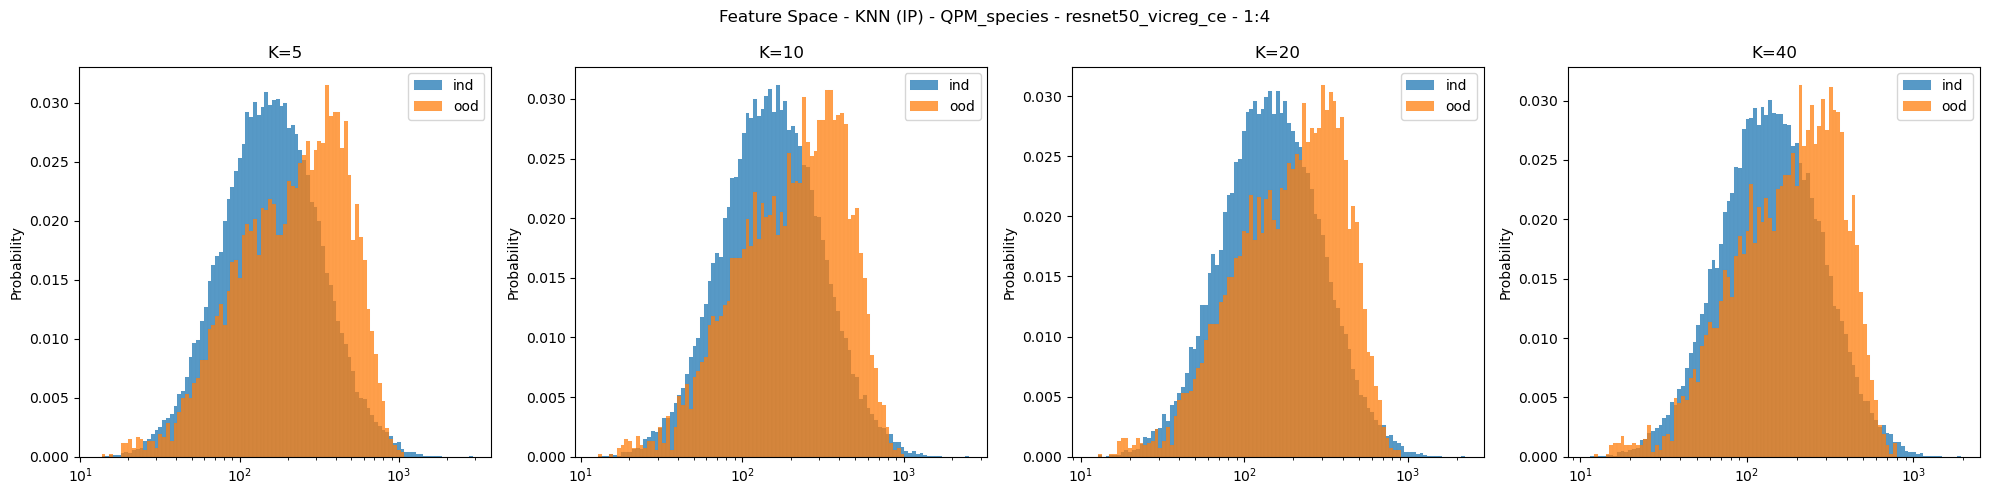

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:02<00:06,  2.10s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:04<00:04,  2.20s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:06<00:02,  2.26s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.42s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.34s/it]

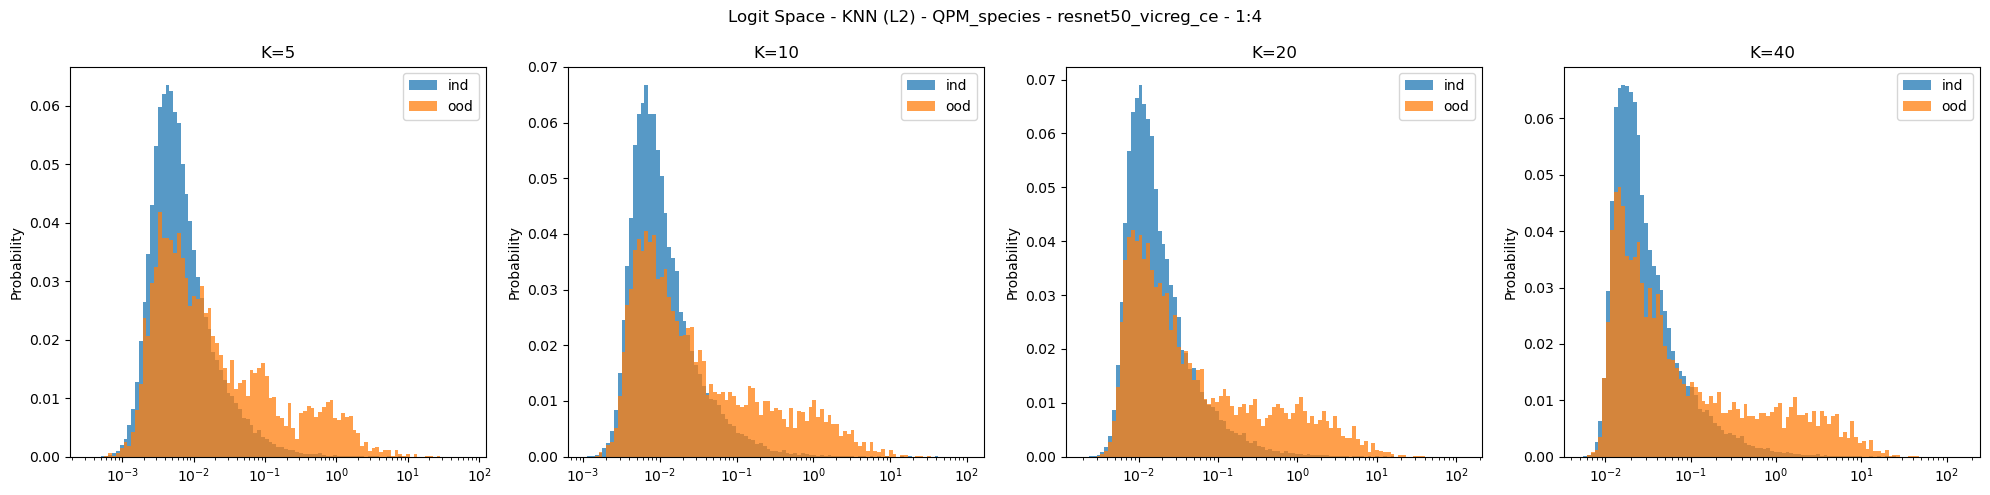

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:05,  1.80s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:03<00:03,  1.85s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:05<00:01,  1.94s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

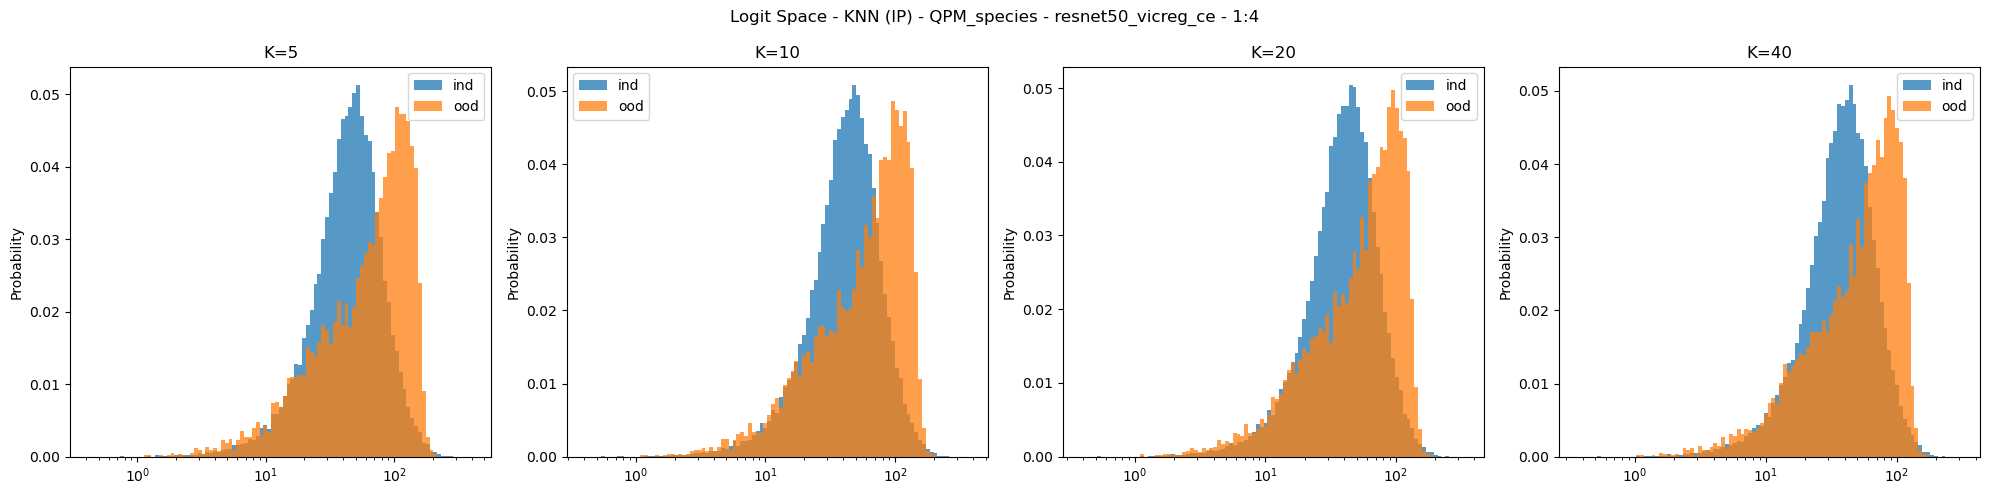

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

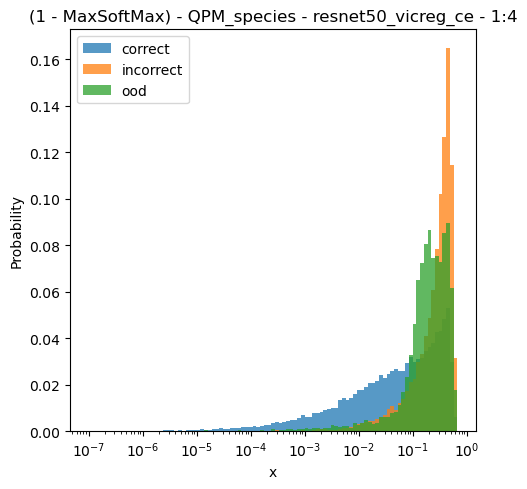

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()